In [12]:
from diffusers import DDPMScheduler

import torch
import torchvision.transforms.functional as F
from PIL import Image
import cv2
import numpy as np
import matplotlib.pyplot as plt

In [45]:
scheduler = DDPMScheduler()

scheduler.set_timesteps(20)

In [46]:
# Load your image (replace 'your_image_path' with the actual path)
image_path = 'images/andrea_room.jpg'
img = cv2.imread(image_path)

In [50]:
img_tensor = F.to_tensor(img)
noise = torch.randn_like(img_tensor)
timestep = torch.tensor(20)

noisy_image = scheduler.add_noise(img_tensor, noise, timestep)

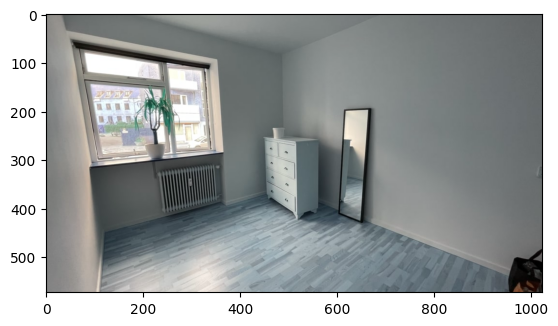

In [51]:
plt.imshow(img_tensor.permute(1, 2, 0))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


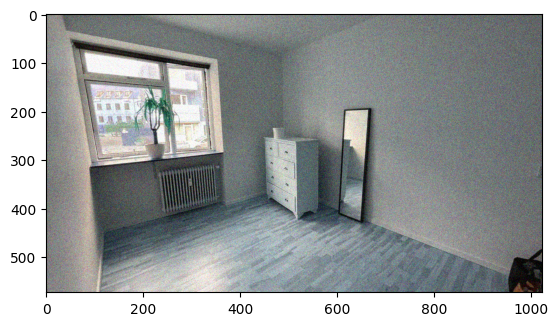

In [52]:
plt.imshow(noisy_image.permute(1, 2, 0))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


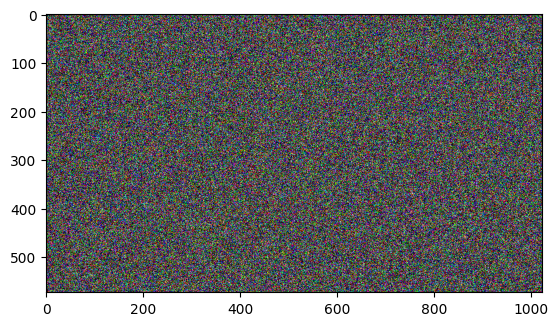

In [53]:
plt.imshow(noise.permute(1, 2, 0))

In [60]:
noise = (noise*255).to(dtype=torch.uint8)

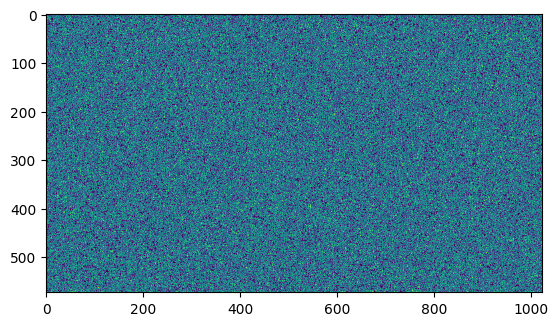

In [63]:
plt.imshow(edges)

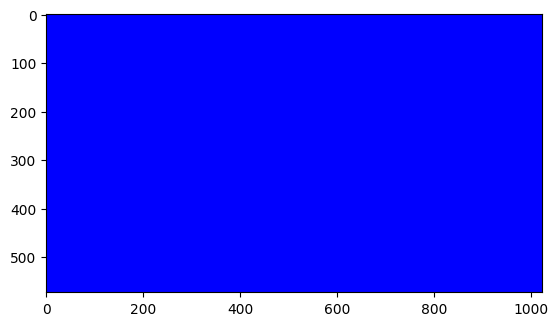

In [65]:
img = noise.permute(1, 2, 0).numpy()
gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
edges = cv2.Canny(gray, 20, 200, apertureSize = 3)

lines = cv2.HoughLines(edges,1,np.pi/180,200)
img = cv2.imread(image_path)
for line in lines:
    rho,theta = line[0]
    a = np.cos(theta)
    b = np.sin(theta)
    x0 = a*rho
    y0 = b*rho
    x1 = int(x0 + 1000*(-b))
    y1 = int(y0 + 1000*(a))
    x2 = int(x0 - 1000*(-b))
    y2 = int(y0 - 1000*(a))
    cv2.line(img,(x1,y1),(x2,y2),(0,0,255),2)
plt.imshow(img)

## Pipe generation

In [14]:
from diffusers import (
    StableDiffusionInpaintPipeline,
    AutoencoderKL,
)

from huggingface_hub import hf_hub_download
from PIL import Image, ImageFilter
import torch

realistic_vision_path = hf_hub_download(repo_id="SG161222/Realistic_Vision_V5.1_noVAE", filename="Realistic_Vision_V5.1-inpainting.safetensors")
vae_path = hf_hub_download(repo_id="stabilityai/sd-vae-ft-mse-original", filename="vae-ft-mse-840000-ema-pruned.safetensors")

print('loading VAE...')
vae = AutoencoderKL.from_single_file(
    vae_path,
)
print('loading model...')
pipe = StableDiffusionInpaintPipeline.from_single_file(
    realistic_vision_path,
    vae=vae,
    torch_dtype=torch.float16,
)

pipe.enable_model_cpu_offload()

loading VAE...
loading model...


`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["id2label"]` will be overriden.
c:\Users\Facundo\AppData\Local\Programs\Python\Python310\lib\site-packages\transformers\models\clip\feature_extraction_clip.py:28: FutureWarning: The class CLIPFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use CLIPImageProcessor instead.
  warnings.warn(
c:\Users\Facundo\AppData\Local\Programs\Python\Python310\lib\site-packages\diffusers\pipelines\pipeline_utils.py:750: FutureWarning: `torch_dtype` is deprecated and will be removed in version 0.25.0. 
  deprecate("torch_dtype", "0.25.0", "")


In [15]:
lora_path = 'loras/kvist_windows_lora_115.safetensors'

pipe.load_lora_weights(lora_path)

In [16]:
pipe.load_textual_inversion('embeddings/easynegative.safetensors')

In [19]:
g_cuda = torch.Generator(device='cuda').manual_seed(42)

prompt = 'kvist windows'
negative_prompt = 'easynegative'

image = Image.open('images/img_kvist.jpg').convert('RGB')
mask = Image.open('images/mask_kvist.png').convert('L')

generated_image = pipe(
    prompt=prompt,
    negative_prompt=negative_prompt,
    image=image,
    mask_image=mask,
    generator=g_cuda,
    num_inference_steps=20,
    height=image.size[0],
    width=image.size[1],
    strength=1, 
    ).images[0]

  0%|          | 0/20 [00:00<?, ?it/s]

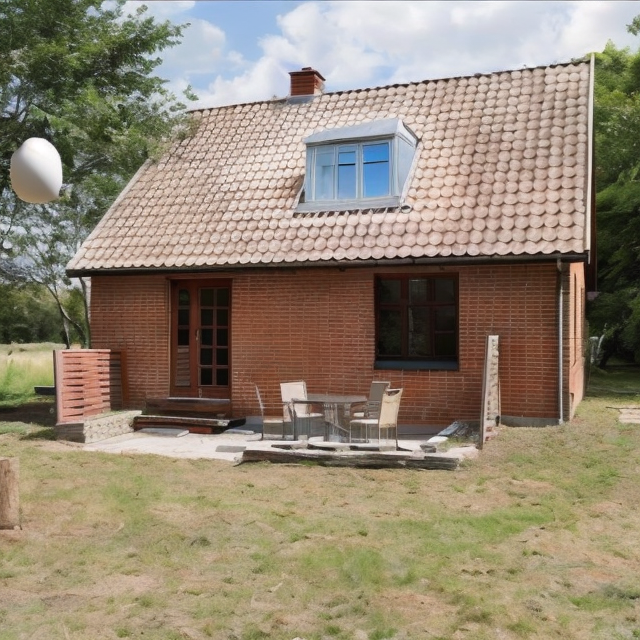

In [20]:
generated_image

In [21]:
from controlnet_aux import MLSDdetector
from PIL import Image

In [2]:
mlsd = MLSDdetector.from_pretrained('lllyasviel/ControlNet')

In [22]:
masked_image = Image.composite(generated_image, Image.new('RGB', generated_image.size, (255, 255, 255)), mask)

In [39]:
import numpy as np
# stack 4 images together
images = torch.stack([torch.tensor(np.array(masked_image)), torch.tensor(np.array(generated_image))])

In [40]:
images = mlsd(images)

AssertionError: 

In [28]:
from diffusers import StableDiffusionInpaintPipeline, logging

In [29]:
logging.set_verbosity_error()

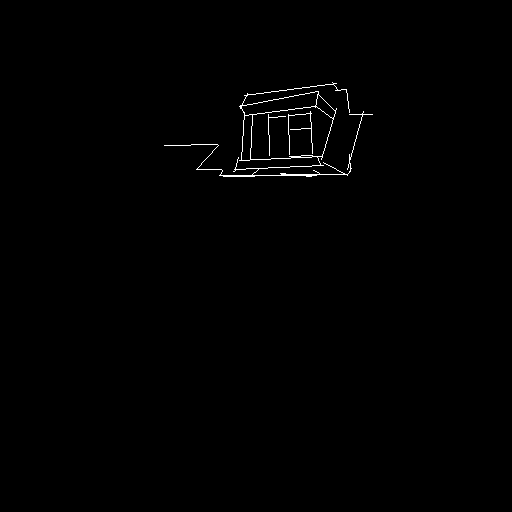

In [27]:
image

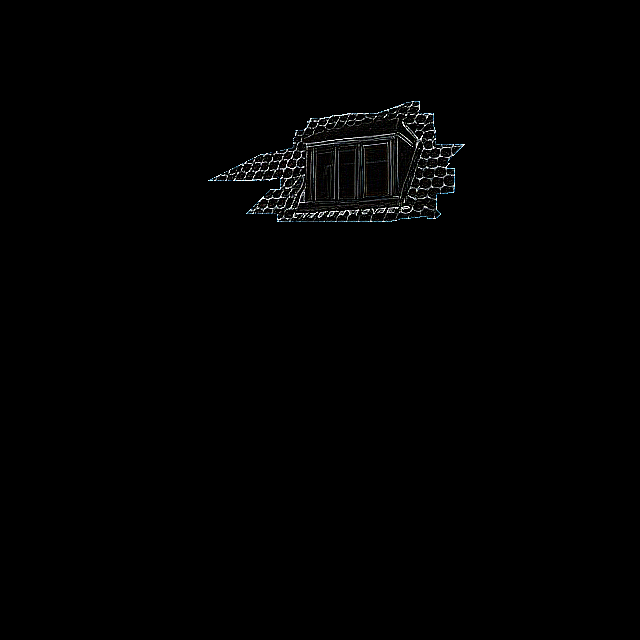

In [61]:
test_image = Image.fromarray(np.array(generated_image) * np.array(mask)[:, :, np.newaxis])
test_image = test_image.filter(ImageFilter.FIND_EDGES)
test_image

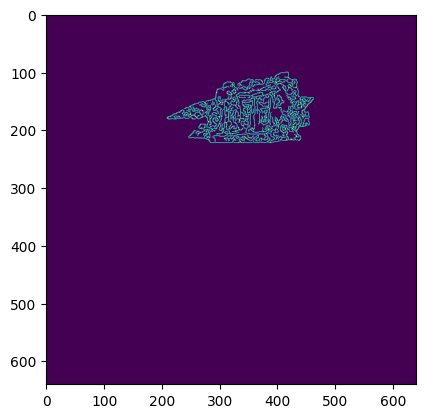

In [64]:
test_image = np.array(test_image)

test_image = test_image * np.array(mask)[:, :, np.newaxis]

gray = cv2.cvtColor(test_image, cv2.COLOR_BGR2GRAY)
blurred = cv2.GaussianBlur(gray, (9, 9), 0)
edges = cv2.Canny(blurred, 20, 150, apertureSize = 3)
plt.imshow(edges)

In [54]:
lines = cv2.HoughLines(edges, 1, np.pi/180, threshold=95)

for line in lines:
    rho,theta = line[0]
    a = np.cos(theta)
    b = np.sin(theta)
    x0 = a*rho
    y0 = b*rho
    x1 = int(x0 + 1000*(-b))
    y1 = int(y0 + 1000*(a))
    x2 = int(x0 - 1000*(-b))
    y2 = int(y0 - 1000*(a))
    cv2.line(test_image,(x1,y1),(x2,y2),(0,0,255),2)

plt.imshow(test_image)

TypeError: 'NoneType' object is not iterable

In [ ]:
img = noise.permute(1, 2, 0).numpy()
gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)


lines = cv2.HoughLines(edges,1,np.pi/180,200)
